## EDA Notebook

Exploration & Exploitation of data trends

In [ ]:
# TODO OPTIMIZE RM3 FOR RECALL (!!) OR A F MEASURE HEAVILY RECALL ORIENTED, PICK PARAMETERS THIS WAY, THEN RERANK, SEE IF IT IMPROVES.

In [2]:
from evaluate_map import evaluate_run, load_run, load_qrels, hardest_queries_report, load_topics

In [14]:
topics = load_topics("Data/queriesROBUST.txt")

In [4]:
import json
def load_vectorid_to_docid(meta_path: str):
    docids = []
    with open(meta_path, "r", encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            docids.append(rec["docid"])
    return docids

vectorid_to_docid = load_vectorid_to_docid(
    f"{FAISS_DIR}/meta.jsonl"
)

In [16]:
from tqdm import tqdm

In [9]:
from sentence_transformers import SentenceTransformer
import faiss
import json
from vdb import search_vdb

encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
FAISS_DIR = "Nottogit/dense_faiss_robust04"
index = faiss.read_index(f"{FAISS_DIR}/faiss_index.bin")
print("Vectors in index:", index.ntotal)

Vectors in index: 2576544


In [10]:
queryf = "poliomyelitis post polio"

result = search_vdb(queryf,index,encoder,FAISS_DIR,k=int(1000*1.5))

In [18]:
for qid, query in tqdm(topics.items(), desc="classifying"):
    hits = search_vdb(query,index,encoder,FAISS_DIR,k=int(1000*1.5))
    with open("vdb_results.txt", "a", encoding="utf-8") as f:
        for rank, hit in enumerate(hits, start=1):
            f.write(
                f"{qid} Q0 {hit.docid} {rank} {hit.score:.6f} runm\n"
            )

classifying: 100%|██████████| 249/249 [40:46<00:00,  9.83s/it]


In [11]:
result

[Hit(docid='LA043090-0036', score=np.float32(0.6005399), qid=None, query=None, text=None, meta={}),
 Hit(docid='LA031489-0032', score=np.float32(0.5990516), qid=None, query=None, text=None, meta={}),
 Hit(docid='LA072890-0066', score=np.float32(0.57625353), qid=None, query=None, text=None, meta={}),
 Hit(docid='FT944-2489', score=np.float32(0.55900586), qid=None, query=None, text=None, meta={}),
 Hit(docid='FT944-2592', score=np.float32(0.55900586), qid=None, query=None, text=None, meta={}),
 Hit(docid='FR940620-2-00118', score=np.float32(0.5523975), qid=None, query=None, text=None, meta={}),
 Hit(docid='FT924-10652', score=np.float32(0.53318083), qid=None, query=None, text=None, meta={}),
 Hit(docid='FBIS3-60562', score=np.float32(0.5298313), qid=None, query=None, text=None, meta={}),
 Hit(docid='LA082490-0065', score=np.float32(0.52849376), qid=None, query=None, text=None, meta={}),
 Hit(docid='FBIS4-67701', score=np.float32(0.52624804), qid=None, query=None, text=None, meta={}),
 Hi

In [6]:
scores[0]

np.float32(0.7151234)

In [33]:
from evaluate_map import *
qrels = load_qrels("Data/qrels_50_Queries")
best_best_run = load_run("run_CE_rrf_0.2.txt")
vanilla_run = load_run("saved_results/run_CE_rrf_1.txt")
res_df_best = evaluate_run(qrels, best_best_run)
res_df_best

,k,MAP,P,Recall,MaxAP,FirstRel,MRR
0,100,0.323692,0.267800,0.513465,0.870165,1.96,0.762302
1,200,0.346752,0.170200,0.583185,0.969760,1.96,0.762302
2,300,0.351314,0.122133,0.608685,0.991465,6.76,0.762385
3,400,0.352252,0.093450,0.614319,0.997857,6.76,0.762385
4,500,0.355210,0.080000,0.636074,1.000000,6.76,0.762385
5,600,0.357655,0.070767,0.658427,1.000000,6.76,0.762385
6,700,0.359292,0.063514,0.673589,1.000000,6.76,0.762385
7,800,0.360405,0.057550,0.686226,1.000000,6.76,0.762385
8,900,0.361242,0.052622,0.694947,1.000000,6.76,0.762385
9,1000,0.362126,0.049000,0.705152,1.000000,6.76,0.762385


In [22]:
qrels = load_qrels("Data/qrels_50_Queries")
best_vdb_run = load_run("vdb_results.txt")
#vanilla_run = load_run("saved_results/run_CE_rrf_1.txt")
res_df_vdb = evaluate_run(qrels, best_vdb_run)
res_df_vdb

,k,MAP,P,Recall,MaxAP,FirstRel,MRR
0,100,0.123568,0.145600,0.294032,0.870165,5.20,0.544793
1,200,0.135928,0.100400,0.363772,0.969760,5.20,0.544793
2,300,0.139006,0.075467,0.389814,0.991465,11.16,0.544860
3,400,0.140094,0.059900,0.410877,0.997857,18.08,0.544918
4,500,0.140366,0.048800,0.414462,1.000000,18.08,0.544918
5,600,0.140564,0.041400,0.416469,1.000000,18.08,0.544918
6,700,0.140594,0.035571,0.416649,1.000000,18.08,0.544918
7,800,0.140594,0.031125,0.416649,1.000000,18.08,0.544918
8,900,0.140594,0.027667,0.416649,1.000000,18.08,0.544918
9,1000,0.140597,0.024920,0.416826,1.000000,18.08,0.544918


In [32]:
qrels = load_qrels("Data/qrels_50_Queries")
fused_run = load_run("Results/run_None_rrf_rerank_0.txt")
# best recall - [0.4 sem, 0.6 lex, rrf_k=200] 0.643
res_df_fused = evaluate_run(qrels, fused_run)
res_df_fused

,k,MAP,P,Recall,MaxAP,FirstRel,MRR
0,100,0.226712,0.209600,0.428368,0.870165,4.76,0.719108
1,200,0.248754,0.147700,0.543122,0.969760,4.76,0.719108
2,300,0.258491,0.117467,0.608093,0.991465,9.02,0.719202
3,400,0.263696,0.098000,0.643166,0.997857,9.02,0.719202
4,500,0.266947,0.084520,0.669353,1.000000,9.02,0.719202
5,600,0.269085,0.074133,0.689273,1.000000,9.02,0.719202
6,700,0.270571,0.066200,0.701760,1.000000,9.02,0.719202
7,800,0.271899,0.060300,0.715414,1.000000,9.02,0.719202
8,900,0.272843,0.055222,0.733045,1.000000,9.02,0.719202
9,1000,0.273525,0.050820,0.742918,1.000000,9.02,0.719202


In [8]:
qrels = load_qrels("Data/qrels_50_Queries")
best_run = load_run("saved_results/run_CE_rrf_0.5.txt")
vanilla_run = load_run("saved_results/run_CE_rrf_1.txt")
res_df_best = evaluate_run(qrels, best_run)
res_df_best

,k,MAP,P,Recall,MaxAP,FirstRel,MRR
0,100,0.273611,0.232600,0.463179,0.870165,3.3,0.701653
1,200,0.294971,0.155400,0.551272,0.969760,3.3,0.701653
2,300,0.301954,0.117133,0.597928,0.991465,7.9,0.701740
3,400,0.304425,0.092600,0.612870,0.997857,7.9,0.701740
4,500,0.307171,0.079120,0.632644,1.000000,7.9,0.701740
5,600,0.309109,0.069500,0.651746,1.000000,7.9,0.701740
6,700,0.310433,0.062029,0.664691,1.000000,7.9,0.701740
7,800,0.311519,0.056125,0.675675,1.000000,7.9,0.701740
8,900,0.312548,0.051756,0.686166,1.000000,7.9,0.701740
9,1000,0.313282,0.047800,0.694228,1.000000,7.9,0.701740


In [9]:
res_df_van = evaluate_run(qrels, vanilla_run)
res_df_van

,k,MAP,P,Recall,MaxAP,FirstRel,MRR
0,100,0.241210,0.206800,0.422942,0.870165,7.62,0.650253
1,200,0.260767,0.143600,0.527109,0.969760,10.54,0.650390
2,300,0.268545,0.111867,0.575200,0.991465,10.54,0.650390
3,400,0.273267,0.092600,0.612870,0.997857,10.54,0.650390
4,500,0.276013,0.079120,0.632644,1.000000,10.54,0.650390
5,600,0.277951,0.069500,0.651746,1.000000,10.54,0.650390
6,700,0.279275,0.062029,0.664691,1.000000,10.54,0.650390
7,800,0.280361,0.056125,0.675675,1.000000,10.54,0.650390
8,900,0.281390,0.051756,0.686166,1.000000,10.54,0.650390
9,1000,0.282124,0.047800,0.694228,1.000000,10.54,0.650390


In [10]:
report_dict = hard_reports = hardest_queries_report(
    qrels=qrels,
    run_before=vanilla_run,
    run_after=best_run,
    k=1000,
    top_x=10
)
report_dict.keys()

dict_keys(['lowest_recall', 'most_missed', 'largest_ap_drop', 'smallest_ap_gain'])

In [13]:
report_dict['most_missed']

,qid,num_rel,ap_before,p_before,recall_before,missed_before,ap_after,p_after,recall_after,missed_after,ap_delta
0,301,448,0.054014,0.101,0.225446,347,0.093178,0.101,0.225446,347,0.039164
1,343,258,0.010904,0.037,0.143411,221,0.016053,0.037,0.143411,221,0.005149
2,306,332,0.162673,0.150,0.451807,182,0.199689,0.150,0.451807,182,0.037015
3,304,196,0.105256,0.088,0.448980,108,0.099714,0.088,0.448980,108,-0.005542
4,332,254,0.103625,0.148,0.582677,106,0.121333,0.148,0.582677,106,0.017709
5,318,113,0.012710,0.012,0.106195,101,0.018729,0.012,0.106195,101,0.006018
6,331,213,0.300508,0.114,0.535211,99,0.351934,0.114,0.535211,99,0.051427
7,321,203,0.316394,0.117,0.576355,86,0.356642,0.117,0.576355,86,0.040248
8,347,152,0.037372,0.076,0.500000,76,0.038256,0.076,0.500000,76,0.000883
9,346,105,0.035705,0.045,0.428571,60,0.042008,0.045,0.428571,60,0.006303


Getting the number of relevant docs per query

In [5]:
from collections import defaultdict
from pathlib import Path

QRELS_PATH = Path("Data/qrels_50_Queries")

def count_relevant_per_query(qrels_path: Path):
    """
    Returns dict: topic -> number of relevant documents
    """
    rel_counts = defaultdict(int)

    with qrels_path.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) < 4:
                raise ValueError(f"Bad qrels format at line {line_no}: {line!r}")

            topic, _, _, rel = parts[:4]
            if int(rel) > 0:
                rel_counts[topic] += 1

    return dict(rel_counts)

Detecting Hard Queries:

In [7]:
for topic, cnt in sorted(rel_per_query.items(), key=lambda x: x[1]):
    print(f"Topic {topic}: {cnt}")


Topic 309: 3
Topic 308: 4
Topic 338: 4
Topic 344: 5
Topic 348: 5
Topic 320: 6
Topic 328: 8
Topic 334: 9
Topic 303: 10
Topic 339: 10
Topic 312: 11
Topic 327: 11
Topic 336: 12
Topic 310: 13
Topic 317: 14
Topic 342: 20
Topic 325: 24
Topic 316: 34
Topic 322: 34
Topic 305: 35
Topic 329: 35
Topic 345: 38
Topic 314: 44
Topic 326: 46
Topic 330: 60
Topic 323: 61
Topic 302: 65
Topic 333: 65
Topic 335: 66
Topic 315: 67
Topic 350: 68
Topic 340: 69
Topic 349: 73
Topic 341: 78
Topic 313: 93
Topic 337: 93
Topic 346: 105
Topic 318: 113
Topic 347: 152
Topic 324: 161
Topic 319: 170
Topic 311: 182
Topic 304: 196
Topic 321: 203
Topic 307: 210
Topic 331: 213
Topic 332: 254
Topic 343: 258
Topic 306: 332
Topic 301: 448


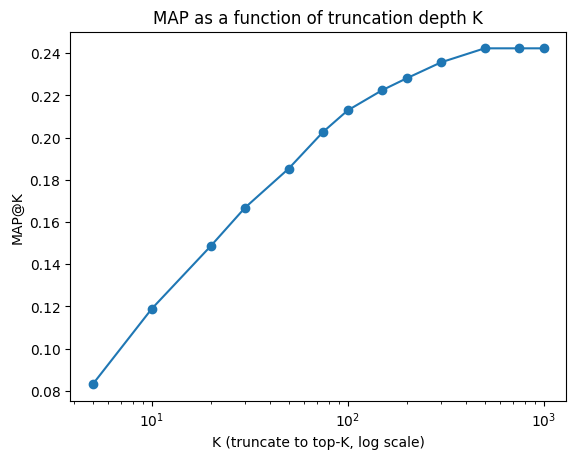

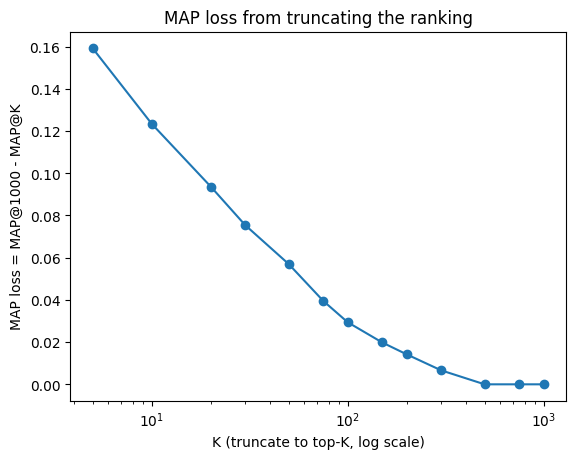

MAP@1000: 0.24225420721175706
K=   5  MAP@K=0.083070  loss=0.159184
K=  10  MAP@K=0.118816  loss=0.123438
K=  20  MAP@K=0.148540  loss=0.093714
K=  30  MAP@K=0.166826  loss=0.075428
K=  50  MAP@K=0.185255  loss=0.056999
K=  75  MAP@K=0.202686  loss=0.039568
K= 100  MAP@K=0.212832  loss=0.029422
K= 150  MAP@K=0.222409  loss=0.019845
K= 200  MAP@K=0.228046  loss=0.014208
K= 300  MAP@K=0.235630  loss=0.006625
K= 500  MAP@K=0.242254  loss=0.000000
K= 750  MAP@K=0.242254  loss=0.000000
K=1000  MAP@K=0.242254  loss=0.000000


In [3]:
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

RUN_PATH   = Path("Results/run.txt")  # <-- change to your res_i file

def read_qrels_relevant(qrels_path: Path):
    rel = defaultdict(set)  # topic -> {relevant docids}
    topics = set()
    with qrels_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            topic, _, docid, r = parts[:4]
            topics.add(topic)
            if int(r) > 0:
                rel[topic].add(docid)
    return rel, sorted(topics, key=int)

def read_run(run_path: Path):
    run = defaultdict(list)  # topic -> ranked docids (file order)
    with run_path.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 6:
                raise ValueError(f"Bad run format at line {line_no}: {line!r}")
            topic, _, docid, rank, score, tag = parts
            run[topic].append(docid)
    return run

def average_precision(ranked_docids, relevant_set):
    R = len(relevant_set)
    if R == 0:
        return 0.0
    hits = 0
    s = 0.0
    for k, d in enumerate(ranked_docids, start=1):
        if d in relevant_set:
            hits += 1
            s += hits / k
    return s / R

def MAP_at_K(run, rel, topics, K=None):
    aps = []
    for t in topics:
        ranked = run.get(t, [])
        if K is not None:
            ranked = ranked[:K]
        aps.append(average_precision(ranked, rel.get(t, set())))
    return sum(aps) / len(aps) if aps else 0.0

# ---- compute curve ----
rel, topics = read_qrels_relevant(QRELS_PATH)
run = read_run(RUN_PATH)

K_list = [5,10,20,30,50,75,100,150,200,300,500,750,1000]
map_1000 = MAP_at_K(run, rel, topics, K=1000)

map_at_k = [MAP_at_K(run, rel, topics, K=k) for k in K_list]
loss_at_k = [map_1000 - m for m in map_at_k]

plt.figure()
plt.plot(K_list, map_at_k, marker="o")
plt.xscale("log")
plt.xlabel("K (truncate to top-K, log scale)")
plt.ylabel("MAP@K")
plt.title("MAP as a function of truncation depth K")
plt.show()

plt.figure()
plt.plot(K_list, loss_at_k, marker="o")
plt.xscale("log")
plt.xlabel("K (truncate to top-K, log scale)")
plt.ylabel("MAP loss = MAP@1000 - MAP@K")
plt.title("MAP loss from truncating the ranking")
plt.show()

print("MAP@1000:", map_1000)
for k, m, l in zip(K_list, map_at_k, loss_at_k):
    print(f"K={k:4d}  MAP@K={m:.6f}  loss={l:.6f}")
